In [177]:
from HelpFunctions.date_and_time import most_recent_thursday, split_time
from DAX.HelpFunctions.get_dax_data import get_dax_data
from datetime import timedelta
from HelpFunctions.calc_score import evaluate_horizon
import pandas as pd
from DAX.Models.baseline import baseline
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

# import importlib
# importlib.reload(Energy.Models)

In [ ]:
df = get_dax_data()

In [ ]:
# We have to start with the tuesday data
start_date_excl = most_recent_thursday(df) - timedelta(days=1)
df_cval = df.loc[df.index < start_date_excl]
df_cval.index = df_cval.index.date

In [ ]:
df_cval.tail()

In [ ]:
def evaluate_models(models, df, last_x, years =False, months=False, weeks=False):
    # Check that exactly one of the boolean parameters is True
    if sum([years, months, weeks]) != 1:
        raise ValueError("Exactly one of the boolean parameters (years, months, weeks) must be True.")
    
    years = int(years)
    months = int(months)
    weeks = int(weeks)
        
    for m in models:
        print(f'*********** Start the evaluation of Model {m["name"]} ***********')
        m['evaluation'] = evaluate_model(m, df, last_x, years, months, weeks)
        
def evaluate_model(model, df, last_x, years, months, weeks):
    df_before = df
    evaluation = pd.DataFrame()
    
    for w in range(last_x):
        print(f'Iteration {w+1} of {last_x}')
        df_before, df_after = split_time(df_before, num_years=years, num_months=months, num_weeks=weeks)
        pred = model['function'](df_before)
        # Makes sure we try to find observations for dates that have an observation (e.g. 05-01 is missing)
        dates = [d for d in pred['forecast_date'] if d in df.index]
        obs = pd.DataFrame({'ret1': df.loc[dates]['ret1']})
        pred = pred.set_index('forecast_date')
        obs.index = obs.index.strftime('%Y-%m-%d')
        # obs.index = obs.index.date
        # pred.index = pd.to_datetime(pred.index).date
        merged_df = pd.merge(pred, obs, left_index=True, right_index=True) 
    
         # Add scores to the merged_df
        for index, row in merged_df.iterrows():
            quantile_preds = row[['q0.025','q0.25','q0.5','q0.75','q0.975']]
            observation = row['ret1']
            score = evaluate_horizon(quantile_preds, observation)
            merged_df.at[index, 'score'] = score
        # print(merged_df[['q0.025','q0.25','q0.5','q0.75','q0.975']])
        evaluation = pd.concat([evaluation, merged_df])
    evaluation = evaluation.sort_index()
    return evaluation

In [ ]:
models = [
    {
        'name': 'baseline',
        'function': baseline
     },
]


In [ ]:
evaluate_models(models, df, 100, weeks=True)

In [128]:
with open('./Model evaluations/baseline.pkl', 'wb') as f:
    pickle.dump(models, f)
#         
# with open('./Model evaluations/baseline.pkl', 'rb') as f:
#     models = pickle.load(f)

In [131]:
models[0]['evaluation']

,target,horizon,q0.025,q0.25,q0.5,q0.75,q0.975,ret1,score
2021-12-17,DAX,1 day,-2.710994,-0.485397,0.075470,0.662321,2.438222,-0.671907,1.951719
2021-12-20,DAX,2 day,-3.936562,-0.748017,0.162165,0.914373,3.132972,-1.898059,5.544979
2021-12-21,DAX,5 day,-4.759447,-0.849379,0.165364,1.226143,3.890326,1.354143,2.915028
2021-12-22,DAX,6 day,-5.246158,-0.964597,0.242305,1.414134,4.574074,0.940890,2.378962
2021-12-23,DAX,7 day,-5.753083,-1.093500,0.385871,1.493921,5.192237,1.038867,2.493972
...,...,...,...,...,...,...,...,...,...
2023-11-13,DAX,1 day,-3.321265,-0.551383,0.057215,0.715600,2.719772,0.723434,1.617430
2023-11-14,DAX,2 day,-4.087895,-0.823250,0.072355,0.978977,3.570492,1.740578,4.475457
2023-11-15,DAX,5 day,-5.259161,-0.917655,0.147247,1.209531,4.628697,0.852870,2.263609
2023-11-16,DAX,6 day,-6.282629,-1.044070,0.185156,1.435721,5.367396,0.243797,1.881038


In [173]:
horizons = [str(i) + " day" for i in (1, 2, 5, 6, 7)]
scores = []
names = []
for m in models:
    scores_m = m['evaluation'].loc[:,('horizon','score')]
    scores.append(scores_m)


score_df = pd.concat(scores, axis=1)


In [174]:
score_df

,horizon,score
2021-12-17,1 day,1.951719
2021-12-20,2 day,5.544979
2021-12-21,5 day,2.915028
2021-12-22,6 day,2.378962
2021-12-23,7 day,2.493972
...,...,...
2023-11-13,1 day,1.617430
2023-11-14,2 day,4.475457
2023-11-15,5 day,2.263609
2023-11-16,6 day,1.881038


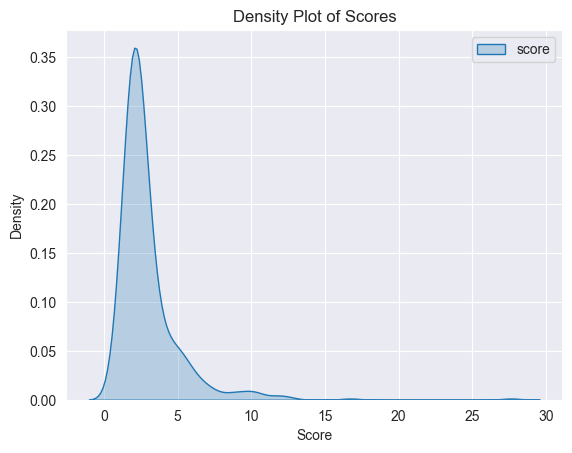

In [178]:
sns.kdeplot(data=score_df.loc[:,['score']], fill=True)

# Adding labels and title
plt.xlabel('Score')
plt.ylabel('Density')
plt.title('Density Plot of Scores')

# Display the plot
plt.show()